In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import pingouin as pg
import string
import math

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Data Preprocessing

In [2]:
data = pd.read_csv('Employee_Salaries_-_2023.csv')
data = data.iloc[:,:7]
data

,Department,Department_Name,Division,Gender,Base_Salary,Overtime_Pay,Longevity_Pay
0,ABS,Alcohol Beverage Services,ABS 85 Administration,M,175873.0000,0.00,0.00
1,ABS,Alcohol Beverage Services,ABS 85 Administration,M,145613.3600,0.00,0.00
2,ABS,Alcohol Beverage Services,ABS 85 Administration,F,136970.0000,0.00,0.00
3,ABS,Alcohol Beverage Services,ABS 85 Administrative Services,F,89432.6940,0.00,2490.00
4,ABS,Alcohol Beverage Services,ABS 85 Administrative Services,F,78947.0000,456.68,6257.70
...,...,...,...,...,...,...,...
10286,TBS,Department of Technology and Enterprise Busine...,TBS 34 OSP Low Code Governance and Administration,M,134500.0000,0.00,0.00
10287,ZAH,Office of Zoning and Administrative Hearings,ZAH 05 Director,F,215032.1000,0.00,0.00
10288,ZAH,Office of Zoning and Administrative Hearings,ZAH 05 Office of Zoning and Administrative Hea...,F,84365.5529,0.00,0.00
10289,ZAH,Office of Zoning and Administrative Hearings,ZAH 05 Zoning and Administrative Hearings,F,98228.0000,0.00,1596.27


In [3]:
# all department names
data['Department_Name'].unique()

array(['Alcohol Beverage Services', 'Board of Appeals Department',
       'Board of Elections', "County Attorney's Office", 'County Council',
       'Community Engagement Cluster', 'Offices of the County Executive',
       'Correction and Rehabilitation',
       'Community Use of Public Facilities',
       'Department of Environmental Protection',
       'Department of General Services',
       'Office of Emergency Management and Homeland Security',
       'Department of Transportation',
       'Department of Permitting Services', 'Ethics Commission',
       'Department of Finance', 'Fire and Rescue Services',
       'Department of Housing and Community Affairs',
       'Department of Health and Human Services',
       'Office of Human Rights',
       'Office of Intergovernmental Relations Department',
       'Department of Public Libraries',
       'Merit System Protection Board Department',
       'Non-Departmental Account', 'Office of Agriculture',
       'Office of Animal Services'

In [4]:
M = data[data.Gender=='M'].groupby('Division')['Gender'].count()
F = data[data.Gender=='F'].groupby('Division')['Gender'].count()
len(M), len(F)

(548, 501)

In [5]:
data.Division.nunique()

627

In [6]:
# choose divisions with both males and females
data1 = data[data.Division.isin(M.index) & data.Division.isin(F.index)]
data1.Division.nunique()

422

In [7]:
# number of divisions of each department
div = data1.groupby('Department_Name')['Division'].nunique()[(data1.groupby('Department_Name')['Division'].nunique())>4]
div

Department_Name
Alcohol Beverage Services                                     34
Community Engagement Cluster                                   6
Correction and Rehabilitation                                 22
County Attorney's Office                                       8
Department of Environmental Protection                        18
Department of Finance                                         13
Department of General Services                                14
Department of Health and Human Services                       11
Department of Housing and Community Affairs                   11
Department of Permitting Services                             17
Department of Police                                          78
Department of Public Libraries                                27
Department of Recreation                                       9
Department of Technology and Enterprise Business Solutions    18
Department of Transportation                                  31
Fire and 

In [8]:
# number of employees of each department
data1.groupby('Department_Name')['Division'].count()[(data1.groupby('Department_Name')['Division'].nunique())>4]

Department_Name
Alcohol Beverage Services                                      322
Community Engagement Cluster                                    95
Correction and Rehabilitation                                  473
County Attorney's Office                                        71
Department of Environmental Protection                         179
Department of Finance                                          109
Department of General Services                                 291
Department of Health and Human Services                       1877
Department of Housing and Community Affairs                     83
Department of Permitting Services                              195
Department of Police                                          1701
Department of Public Libraries                                 402
Department of Recreation                                       186
Department of Technology and Enterprise Business Solutions      85
Department of Transportation                  

In [9]:
# r means number of males or females sampled from a division
r = 3
M_count = data1[data1.Gender=='M'].groupby('Division')['Gender'].count()
F_count = data1[data1.Gender=='F'].groupby('Division')['Gender'].count()
M_index = M_count[M_count>=r].index
F_index = F_count[F_count>=r].index
data2 = data1[data1.Division.isin(M_index) & data1.Division.isin(F_index)]
data2.Division.nunique()

180

In [10]:
# n means divisions sampled from a department
n = 6
div = data2.groupby('Department_Name')['Division'].nunique()[(data2.groupby('Department_Name')['Division'].nunique())>=n]
len(div)

12

In [11]:
# sampled departments
div.index

Index(['Alcohol Beverage Services', 'Correction and Rehabilitation',
       'Department of Environmental Protection', 'Department of Finance',
       'Department of General Services',
       'Department of Health and Human Services',
       'Department of Permitting Services', 'Department of Police',
       'Department of Public Libraries', 'Department of Recreation',
       'Department of Transportation', 'Fire and Rescue Services'],
      dtype='object', name='Department_Name')

In [12]:
# population for sampling
data2.Department_Name.isin(div.index).sum()

6360

In [13]:
def assign_domain(department_name):
    public_safety_departments = [
        'Alcohol Beverage Services',
        'Correction and Rehabilitation',
        'Department of Police',
        'Fire and Rescue Services',
        'Sheriff\'s Office'
    ]
    
    administrative_departments = [
        'Board of Elections',
        'County Attorney\'s Office',
        'Department of Finance',
        'Department of General Services',
        'Department of Permitting Services',
        'Department of Technology and Enterprise Business Solutions',
        'Office of Human Resources',
        'Office of Procurement',
        'Offices of the County Executive'
    ]
    
    community_departments = [
        'Community Engagement Cluster',
        'Community Use of Public Facilities',
        'Department of Environmental Protection',
        'Department of Health and Human Services',
        'Department of Housing and Community Affairs',
        'Department of Public Libraries',
        'Department of Recreation',
        'Department of Transportation',
        'Office of Public Information'
    ]
    
    if department_name in public_safety_departments:
        return 'Public Safety'
    elif department_name in administrative_departments:
        return 'Administrative Services'
    elif department_name in community_departments:
        return 'Community Services'
    else:
        return None

data3 = data2[data2.Department_Name.isin(div.index)].reset_index(drop=True)
domain = data3['Department_Name'].apply(assign_domain).rename('Domain')
data3 = pd.concat([domain, data3], axis=1)
data3.loc[:,'Total_Salary'] = data3.Base_Salary + data3.Overtime_Pay + data3.Longevity_Pay
data3

,Domain,Department,Department_Name,Division,Gender,Base_Salary,Overtime_Pay,Longevity_Pay,Total_Salary
0,Public Safety,ABS,Alcohol Beverage Services,ABS 85 Administrative Services,F,89432.6940,0.00,2490.00,91922.6940
1,Public Safety,ABS,Alcohol Beverage Services,ABS 85 Administrative Services,F,78947.0000,456.68,6257.70,85661.3800
2,Public Safety,ABS,Alcohol Beverage Services,ABS 85 Administrative Services,F,98228.0000,518.80,998.28,99745.0800
3,Public Safety,ABS,Alcohol Beverage Services,ABS 85 Administrative Services,F,82405.3864,549.20,0.00,82954.5864
4,Public Safety,ABS,Alcohol Beverage Services,ABS 85 Administrative Services,M,93986.0000,1187.06,2452.94,97626.0000
...,...,...,...,...,...,...,...,...,...
6355,Community Services,REC,Department of Recreation,REC 72 Facilities Division,F,56341.7500,0.00,0.00,56341.7500
6356,Community Services,REC,Department of Recreation,REC 72 Facilities Division,M,66031.8874,0.00,0.00,66031.8874
6357,Community Services,REC,Department of Recreation,REC 72 Facilities Division,M,56000.0000,0.00,0.00,56000.0000
6358,Community Services,REC,Department of Recreation,REC 72 Facilities Division,F,105376.9104,0.00,0.00,105376.9104


In [14]:
# number of departments in each domain
data3.groupby('Domain')['Department_Name'].nunique()

Domain
Administrative Services    3
Community Services         5
Public Safety              4
Name: Department_Name, dtype: int64

In [15]:
# fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=False)

# sns.boxplot(y='Domain', x='Base_Salary', data=data3, ax=axes[0])
# axes[0].set_title('Base Salary by Domain')
# axes[0].set_ylabel('Domain')
# axes[0].set_xlabel('Base Salary')

# sns.boxplot(y='Domain', x='Total_Salary', data=data3, ax=axes[1])
# axes[1].set_title('Total Salary by Domain')
# axes[1].set_ylabel('Domain')
# axes[1].set_xlabel('Total Salary')

# plt.tight_layout()
# plt.show()

In [16]:
# fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=False)

# sns.boxplot(y='Domain', x='Overtime_Pay', data=data3, ax=axes[0])
# axes[0].set_title('Overtime Pay by Domain')
# axes[0].set_ylabel('Domain')
# axes[0].set_xlabel('Overtime Pay')

# sns.boxplot(y='Domain', x='Longevity_Pay', data=data3, ax=axes[1])
# axes[1].set_title('Longevity Pay by Domain')
# axes[1].set_ylabel('Domain')
# axes[1].set_xlabel('Longevity Pay')

# plt.tight_layout()
# plt.show()

In [17]:
# fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=False)

# for i, domain in enumerate(data3['Domain'].unique()):
#     subset_data = data3[data3['Domain'] == domain]
    
#     sns.boxplot(x='Base_Salary', y='Department', data=subset_data, ax=axes[i])
    
#     axes[i].set_title(f'Base Salary - {domain}')
#     axes[i].set_xlabel('Base Salary')
#     axes[i].set_ylabel('Department')

# plt.tight_layout()
# plt.show()

In [18]:
# fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=False)

# for i, domain in enumerate(data3['Domain'].unique()):
#     subset_data = data3[data3['Domain'] == domain]
    
#     sns.boxplot(x='Total_Salary', y='Department', data=subset_data, ax=axes[i])
    
#     axes[i].set_title(f'Total Salary - {domain}')
#     axes[i].set_xlabel('Total Salary')
#     axes[i].set_ylabel('Department')

# plt.tight_layout()
# plt.show()

In [19]:
# fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=False)

# sns.boxplot(y='Gender', x='Base_Salary', data=data3, ax=axes[0])
# axes[0].set_title('Base Salary by Gender')
# axes[0].set_ylabel('Gender')
# axes[0].set_xlabel('Base Salary')

# sns.boxplot(y='Gender', x='Total_Salary', data=data3, ax=axes[1])
# axes[1].set_title('Total Salary by Gender')
# axes[1].set_ylabel('Gender')
# axes[1].set_xlabel('Total Salary')

# plt.tight_layout()
# plt.show()

In [20]:
# sns.catplot(x='Domain', y='Base_Salary', hue='Gender', kind='box', data=data3, height=6, aspect=2)

# plt.title('Base Salary by Domain and Gender')
# plt.xlabel('Domain')
# plt.ylabel('Base Salary')

# plt.show()

In [21]:
# sns.catplot(x='Domain', y='Total_Salary', hue='Gender', kind='box', data=data3, height=6, aspect=2)

# plt.title('Total Salary by Domain and Gender')
# plt.xlabel('Domain')
# plt.ylabel('Total Salary')

# plt.show()

In [22]:
# pg.anova(dv='Base_Salary', between=['Domain', 'Gender'], data=data3, detailed=True)

In [23]:
# pg.anova(dv='Total_Salary', between=['Domain', 'Gender'], data=data3, detailed=True)

In [24]:
# # choose data cell with rational variance
# data4 = data3.copy()
# div_var = data4.groupby(['Division', 'Gender'])['Total_Salary'].var()
# condition1 = div_var > 1.75e9
# condition2 = div_var < 1.2e8
# condition1.sum(), condition2.sum()

In [25]:
# data4 = data4[~data4.Division.isin(div_var[condition1|condition2].index.get_level_values('Division'))].reset_index(drop=True)
# data4.groupby('Department_Name')['Division'].nunique()

In [26]:
# thr1 = 380000
# thr2 = 200000
# condition3 = data3.Total_Salary>thr1
# condition4 = (data3.Domain=='Community Services') & (data3.Total_Salary>thr2)
# condition3.sum(), condition4.sum()

In [27]:
# data4 = data3[~(condition3|condition4)].reset_index(drop=True)
# len(data4)

In [28]:
# # new number of divisions in each department
# data4 = data4[~data4.Department.isin(['HHS','DOT','POL'])].reset_index(drop=True)
# data4.groupby('Department_Name')['Division'].nunique()

In [29]:
# # test for homo-variance of base salary
# groups = []
# for (division, gender), group_data in data4.groupby(['Division', 'Gender']):
#     groups.append(group_data['Base_Salary'])
# levene_test_result = stats.levene(*groups)
# print("Levene's Test Result:")
# print("Statistic:", levene_test_result.statistic)
# print("p-value:", levene_test_result.pvalue)

In [30]:
# # test for homo-variance of total salary
# groups = []
# for (division, gender), group_data in data4.groupby(['Division', 'Gender']):
#     groups.append(group_data['Total_Salary'])
# levene_test_result = stats.levene(*groups)
# print("Levene's Test Result:")
# print("Statistic:", levene_test_result.statistic)
# print("p-value:", levene_test_result.pvalue)

In [31]:
# s2 = np.log(data4.groupby(['Division', 'Gender'])['Total_Salary'].var())
# bar = np.log(data4.groupby(['Division', 'Gender'])['Total_Salary'].mean())

# plt.figure(figsize=(8, 6))
# plt.scatter(np.e**bar, np.e**s2, color='blue', alpha=0.7)
# plt.title('Scatter Plot')
# plt.xlabel('Salary Mean')
# plt.ylabel('Salary Variance')
# plt.grid(True)
# plt.show()

In [32]:
# X = sm.add_constant(bar)
# model = sm.OLS(s2, X).fit()
# slope = model.params['Total_Salary']
# power = 1 - slope/2
# power.round(2)

In [33]:
# # transformation and test again
# data5 = data4.copy()
# data5.Total_Salary = (data4.Total_Salary)**power

# groups = []
# for (division, gender), group_data in data5.groupby(['Division', 'Gender']):
#     groups.append(group_data['Total_Salary'])
# levene_test_result = stats.levene(*groups)
# print("Levene's Test Result:")
# print("Statistic:", levene_test_result.statistic)
# print("p-value:", levene_test_result.pvalue)

In [34]:
# pg.anova(dv='Total_Salary', between=['Domain', 'Gender'], data=data5, detailed=True)

# Sampling

In [35]:
# sampling function

def sample(data, psu, ssu, num):
    df = data.copy()
    all_sampled_ssu = np.array([])
    result = {}
    for p in df[psu].unique():
        sampled_ssu = pd.Series(df[df[psu]==p][ssu].unique()).sample(n=num, random_state=19260817)
        all_sampled_ssu = np.concatenate([all_sampled_ssu, sampled_ssu])
        result[p] = sampled_ssu.values
    df = df[df[ssu].isin(all_sampled_ssu)]
    return df, result

In [36]:
# sample 3 departments from each domain

df, result = sample(data3, 'Domain', 'Department', 3)
result

{'Public Safety': array(['POL', 'COR', 'ABS'], dtype=object),
 'Community Services': array(['REC', 'DOT', 'DEP'], dtype=object),
 'Administrative Services': array(['DGS', 'DPS', 'FIN'], dtype=object)}

In [37]:
# sample 6 divisions from each department

df1, result1 = sample(df, 'Department', 'Division', 6)
result1

{'ABS': array(['ABS 85 Retail Administration', 'ABS 85 Leisure World',
        'ABS 85 Administrative Services', 'ABS 85 Aspen Hill',
        'ABS 85 Walnut Hill', 'ABS 85 Kingsview'], dtype=object),
 'COR': array(['COR 42 PTS Supervision', 'COR 42 DS MCCF Unit 2 Security',
        'COR 42 DS MCCF Unit 1 Security',
        'COR 42 PRRS Reentry Services and Programs',
        'COR 42 MSD Fiscal Services', 'COR 42 DS Inmate Records'],
       dtype=object),
 'DEP': array(['DEP 80 Resource Conversion',
        'DEP 80 Administration and Operations',
        'DEP 80 Strategic Services Division',
        'DEP 80 Waste Reduction and Recycling',
        'DEP 80 Stormwater BMP Inspection and Maintenance',
        'DEP 80 Building and Transportation Programs'], dtype=object),
 'DGS': array(['DGS 36 Fleet Management Services', 'DGS 36 Central Duplicating',
        'DGS 36 Building Design and Construction',
        'DGS 36 Fleet Automotive Heavy Equipment',
        'DGS 36 Facilities Maintenance',

In [38]:
df1.groupby(['Division', 'Gender'])['Base_Salary'].count().min()

3

In [39]:
# sample 3 males and 3 females from each division

def sample_group(group):
    if len(group) <= 3:
        return group
    else:
        return group.sample(n=3, random_state=19260817)

df1 = df1.groupby(['Division', 'Gender']).apply(sample_group).reset_index(drop=True)
df1

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18208\2477061636.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df1 = df1.groupby(['Division', 'Gender']).apply(sample_group).reset_index(drop=True)


,Domain,Department,Department_Name,Division,Gender,Base_Salary,Overtime_Pay,Longevity_Pay,Total_Salary
0,Public Safety,ABS,Alcohol Beverage Services,ABS 85 Administrative Services,F,82808.2800,11870.82,0.00,94679.1000
1,Public Safety,ABS,Alcohol Beverage Services,ABS 85 Administrative Services,F,89432.6940,0.00,2490.00,91922.6940
2,Public Safety,ABS,Alcohol Beverage Services,ABS 85 Administrative Services,F,110572.1550,0.00,0.00,110572.1550
3,Public Safety,ABS,Alcohol Beverage Services,ABS 85 Administrative Services,M,63733.0000,1363.23,0.00,65096.2300
4,Public Safety,ABS,Alcohol Beverage Services,ABS 85 Administrative Services,M,93986.0000,1187.06,2452.94,97626.0000
...,...,...,...,...,...,...,...,...,...
319,Community Services,REC,Department of Recreation,REC 72 Youth Development Youth Services,F,82209.1853,0.00,0.00,82209.1853
320,Community Services,REC,Department of Recreation,REC 72 Youth Development Youth Services,F,107367.0000,0.00,4580.14,111947.1400
321,Community Services,REC,Department of Recreation,REC 72 Youth Development Youth Services,M,60000.0000,0.00,0.00,60000.0000
322,Community Services,REC,Department of Recreation,REC 72 Youth Development Youth Services,M,67909.9450,0.00,0.00,67909.9450


In [40]:
df2 = df1.copy()
for key in result:
    old_name = result[key]
    new_name = np.array(list(string.ascii_uppercase)[:len(old_name)])
    mapping_dict = dict(zip(old_name, new_name))
    df2['Department'] = df2['Department'].map(mapping_dict).fillna(df2['Department'])
for key in result1:
    old_name = result1[key]
    new_name = np.array(list(string.ascii_uppercase)[:len(old_name)])
    mapping_dict = dict(zip(old_name, new_name))
    df2['Division'] = df2['Division'].map(mapping_dict).fillna(df2['Division'])
df2.groupby(['Domain', 'Department', 'Division'])['Total_Salary'].count()

Domain                   Department  Division
Administrative Services  A           A           6
                                     B           6
                                     C           6
                                     D           6
                                     E           6
                                     F           6
                         B           A           6
                                     B           6
                                     C           6
                                     D           6
                                     E           6
                                     F           6
                         C           A           6
                                     B           6
                                     C           6
                                     D           6
                                     E           6
                                     F           6
Community Services       A          

# EDA

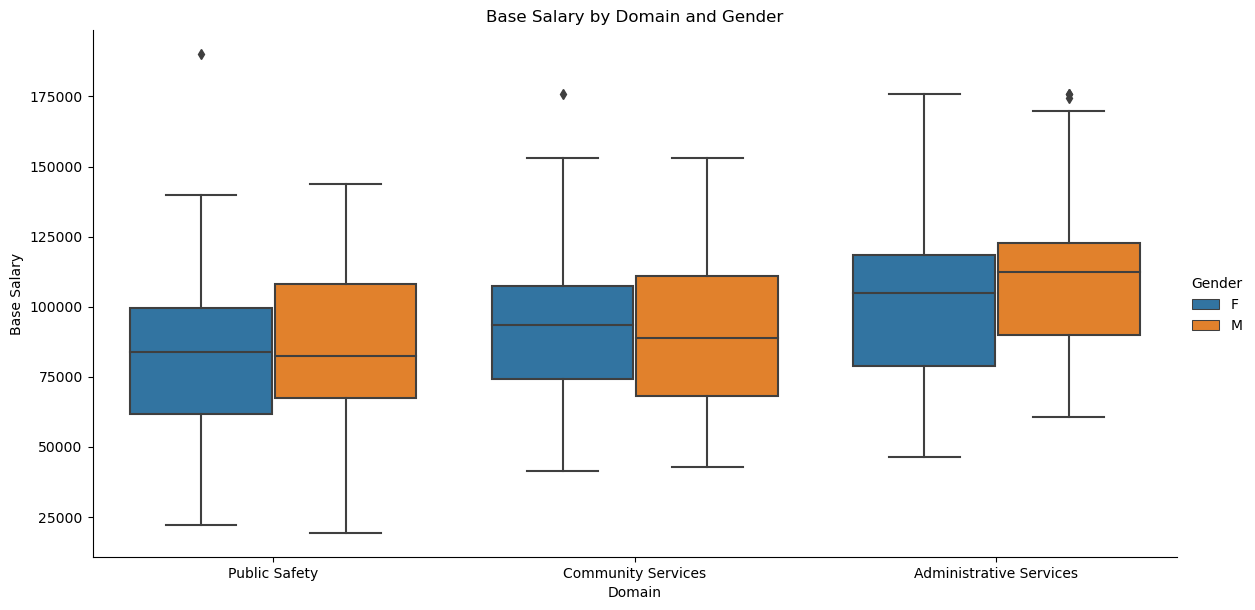

In [41]:
sns.catplot(x='Domain', y='Base_Salary', hue='Gender', kind='box', data=df1, height=6, aspect=2)

plt.title('Base Salary by Domain and Gender')
plt.xlabel('Domain')
plt.ylabel('Base Salary')

plt.show()

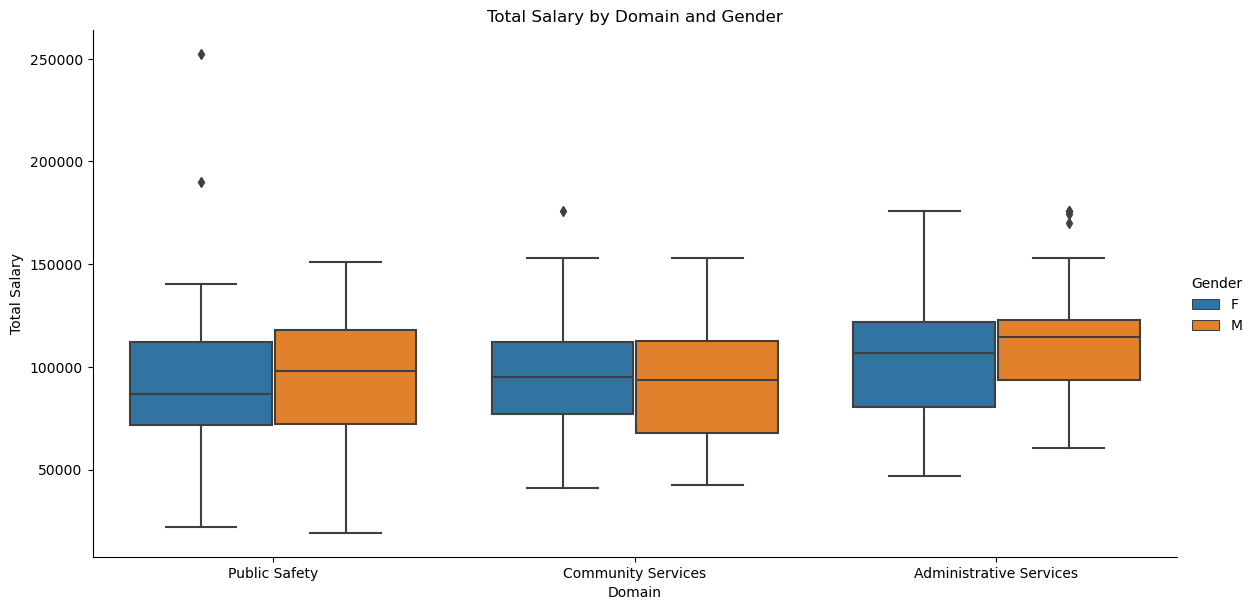

In [42]:
sns.catplot(x='Domain', y='Total_Salary', hue='Gender', kind='box', data=df1, height=6, aspect=2)

plt.title('Total Salary by Domain and Gender')
plt.xlabel('Domain')
plt.ylabel('Total Salary')

plt.show()

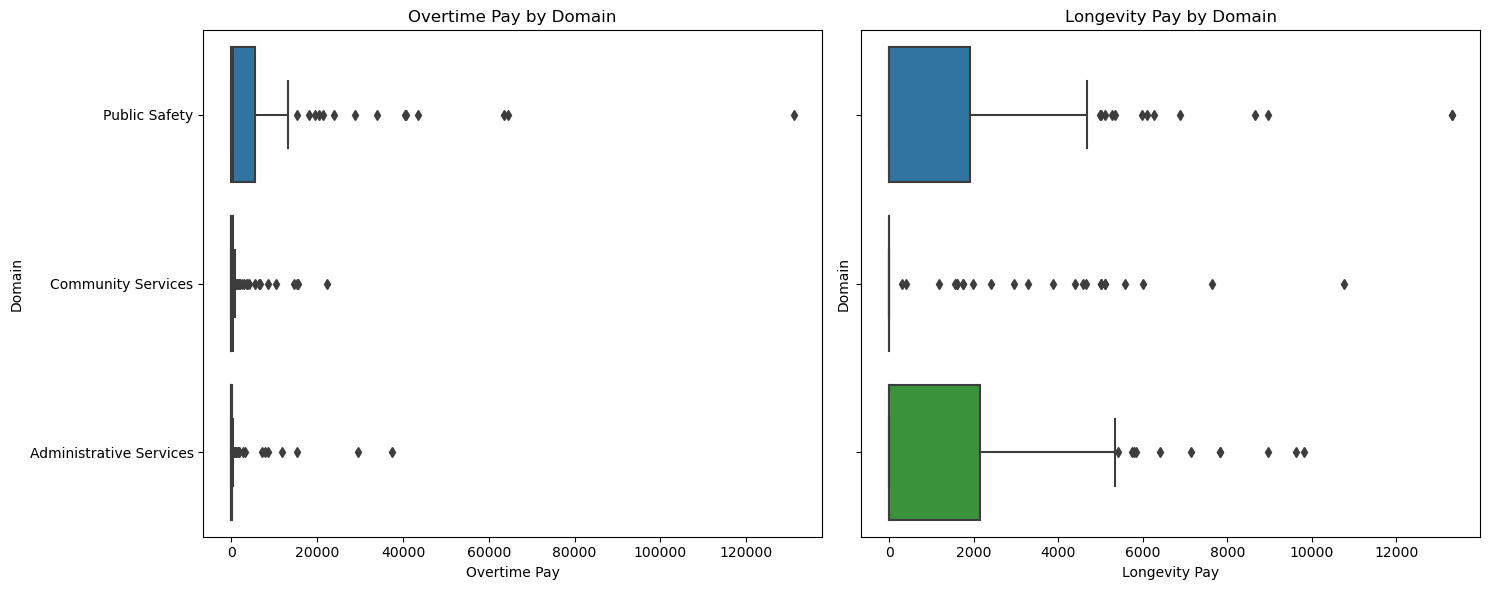

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

sns.boxplot(y='Domain', x='Overtime_Pay', data=df1, ax=axes[0])
axes[0].set_title('Overtime Pay by Domain')
axes[0].set_ylabel('Domain')
axes[0].set_xlabel('Overtime Pay')

sns.boxplot(y='Domain', x='Longevity_Pay', data=df1, ax=axes[1])
axes[1].set_title('Longevity Pay by Domain')
axes[1].set_ylabel('Domain')
axes[1].set_xlabel('Longevity Pay')

plt.tight_layout()
plt.show()

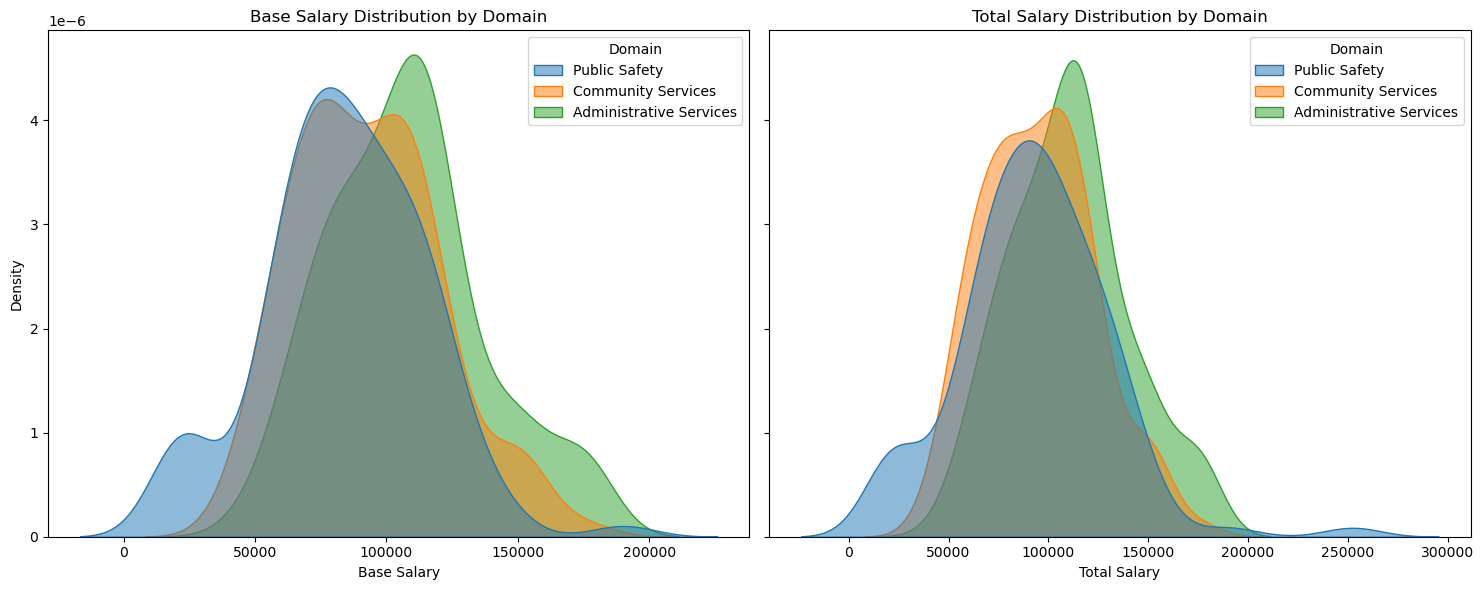

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

sns.kdeplot(data=df1, x='Base_Salary', hue='Domain', fill=True, alpha=0.5, ax=axes[0], multiple='layer')
axes[0].set_title('Base Salary Distribution by Domain')
axes[0].set_xlabel('Base Salary')
axes[0].set_ylabel('Density')

sns.kdeplot(data=df1, x='Total_Salary', hue='Domain', fill=True, alpha=0.5, ax=axes[1], multiple='layer')
axes[1].set_title('Total Salary Distribution by Domain')
axes[1].set_xlabel('Total Salary')
axes[1].set_ylabel('Density')

plt.tight_layout()
plt.show()

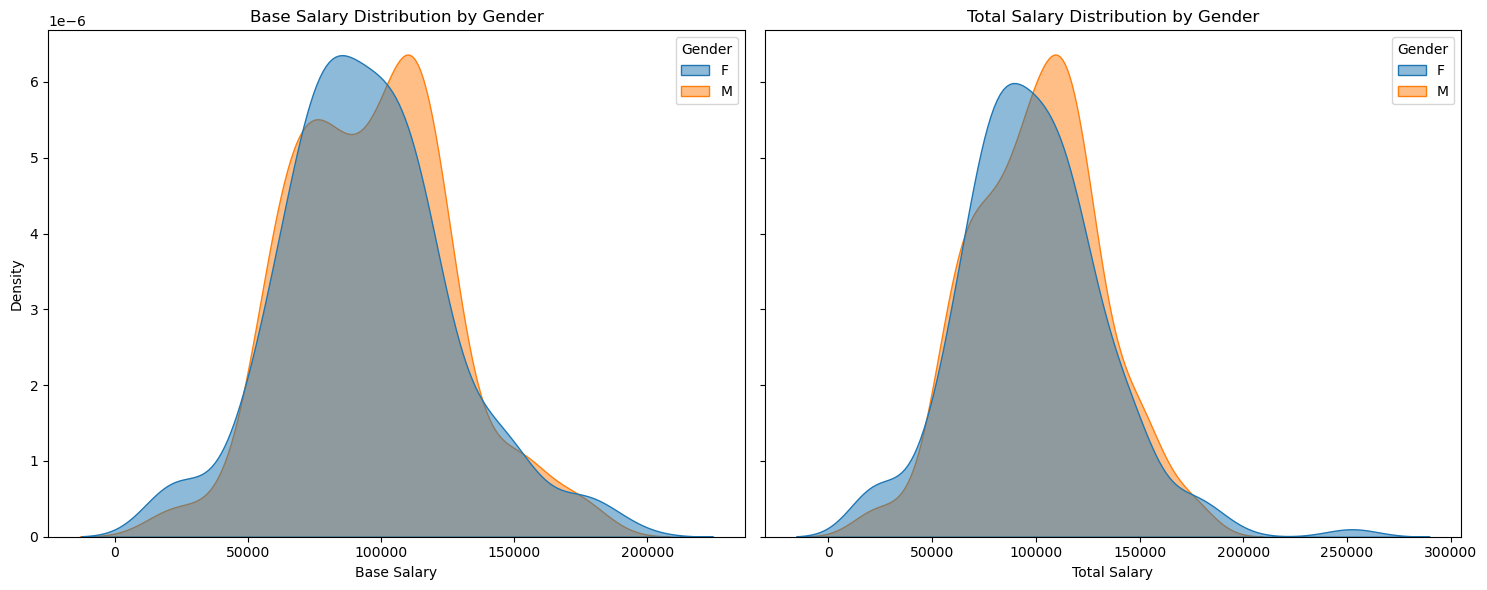

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

sns.kdeplot(data=df1, x='Base_Salary', hue='Gender', fill=True, alpha=0.5, ax=axes[0], multiple='layer')
axes[0].set_title('Base Salary Distribution by Gender')
axes[0].set_xlabel('Base Salary')
axes[0].set_ylabel('Density')

sns.kdeplot(data=df1, x='Total_Salary', hue='Gender', fill=True, alpha=0.5, ax=axes[1], multiple='layer')
axes[1].set_title('Total Salary Distribution by Gender')
axes[1].set_xlabel('Total Salary')
axes[1].set_ylabel('Density')

plt.tight_layout()
plt.show()

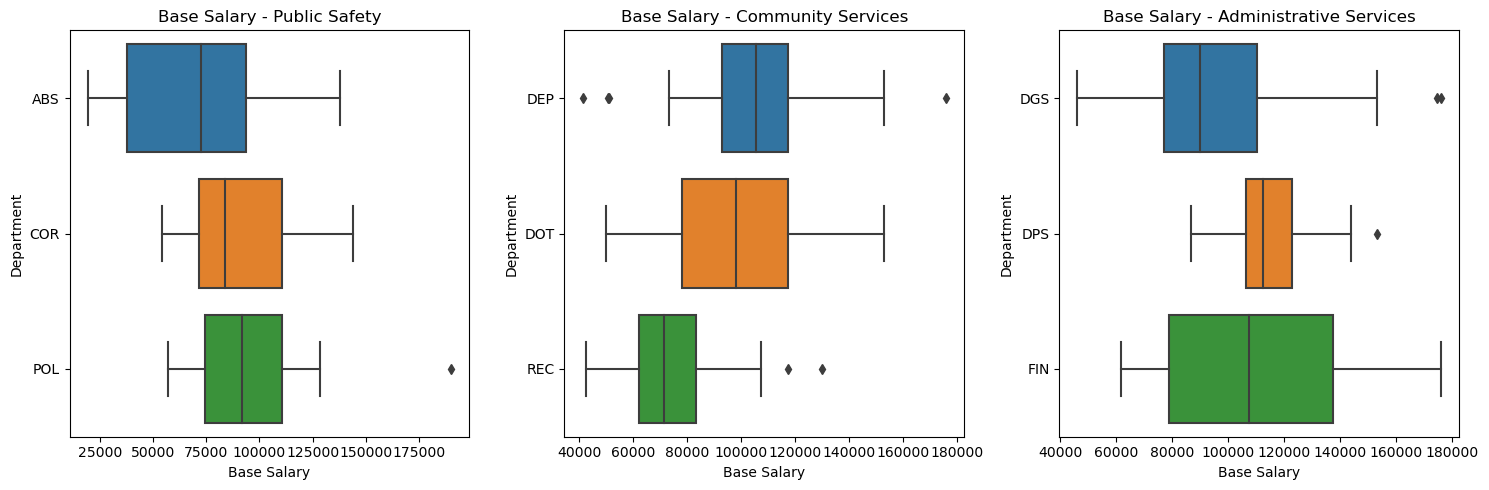

In [46]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=False)

for i, domain in enumerate(df1['Domain'].unique()):
    subset_data = df1[df1['Domain'] == domain]
    
    sns.boxplot(x='Base_Salary', y='Department', data=subset_data, ax=axes[i])
    
    axes[i].set_title(f'Base Salary - {domain}')
    axes[i].set_xlabel('Base Salary')
    axes[i].set_ylabel('Department')

plt.tight_layout()
plt.show()

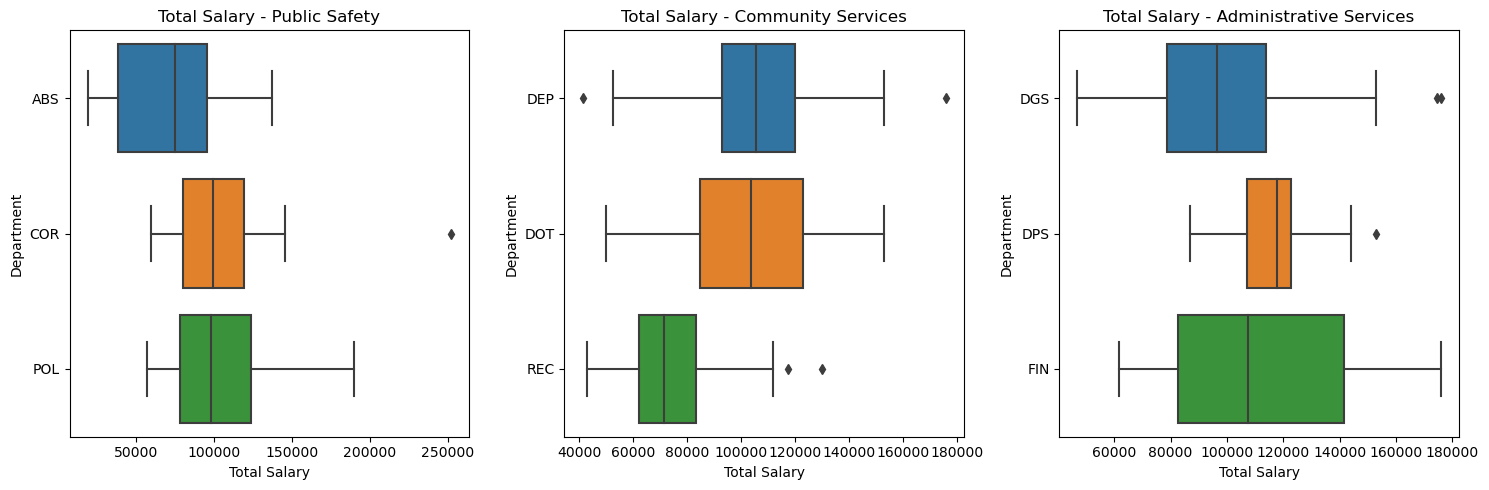

In [47]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=False)

for i, domain in enumerate(df1['Domain'].unique()):
    subset_data = df1[df1['Domain'] == domain]
    
    sns.boxplot(x='Total_Salary', y='Department', data=subset_data, ax=axes[i])
    
    axes[i].set_title(f'Total Salary - {domain}')
    axes[i].set_xlabel('Total Salary')
    axes[i].set_ylabel('Department')

plt.tight_layout()
plt.show()

# Assumptions

In [48]:
grouped = df1.groupby(['Domain', 'Department', 'Division', 'Gender'])

group_means = grouped[['Base_Salary', 'Overtime_Pay', 'Longevity_Pay', 'Total_Salary']].transform('mean')

resid = df1.copy()
resid[['Base_Salary', 'Overtime_Pay', 'Longevity_Pay', 'Total_Salary']] -= group_means
MSE = (resid[['Base_Salary', 'Overtime_Pay', 'Longevity_Pay', 'Total_Salary']]**2).sum() / 216
resid[['Base_Salary', 'Overtime_Pay', 'Longevity_Pay', 'Total_Salary']] /= np.sqrt(MSE)
resid

,Domain,Department,Department_Name,Division,Gender,Base_Salary,Overtime_Pay,Longevity_Pay,Total_Salary
0,Public Safety,ABS,Alcohol Beverage Services,ABS 85 Administrative Services,F,-0.457926,0.915790,-0.344291,-0.160379
1,Public Safety,ABS,Alcohol Beverage Services,ABS 85 Administrative Services,F,-0.193287,-0.457895,0.688581,-0.261334
2,Public Safety,ABS,Alcohol Beverage Services,ABS 85 Administrative Services,F,0.651213,-0.457895,-0.344291,0.421713
3,Public Safety,ABS,Alcohol Beverage Services,ABS 85 Administrative Services,M,0.189458,0.059380,-0.339166,0.162544
4,Public Safety,ABS,Alcohol Beverage Services,ABS 85 Administrative Services,M,1.398036,0.038993,0.678333,1.353964
...,...,...,...,...,...,...,...,...,...
319,Community Services,REC,Department of Recreation,REC 72 Youth Development Youth Services,F,-0.116939,0.000000,-0.633293,-0.163127
320,Community Services,REC,Department of Recreation,REC 72 Youth Development Youth Services,F,0.888091,0.000000,1.266585,0.926041
321,Community Services,REC,Department of Recreation,REC 72 Youth Development Youth Services,M,-0.736087,0.000000,-0.241243,-0.696150
322,Community Services,REC,Department of Recreation,REC 72 Youth Development Youth Services,M,-0.420092,0.000000,-0.241243,-0.406444


## Lack of Fit

In [49]:
# resid['Group_ID'] = pd.factorize(grouped.ngroup())[0]
# fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# axes[0].scatter(resid['Group_ID'], resid['Base_Salary'], alpha=0.6)
# axes[0].set_xlabel('Group ID')
# axes[0].set_ylabel('Residual')
# axes[0].set_title('Scatter Plot of Base Salary by Group')

# axes[1].scatter(resid['Group_ID'], resid['Total_Salary'], alpha=0.6, color='orange')
# axes[1].set_xlabel('Group ID')
# axes[1].set_ylabel('Residual')
# axes[1].set_title('Scatter Plot of Total Salary by Group')

# plt.tight_layout()
# plt.show()

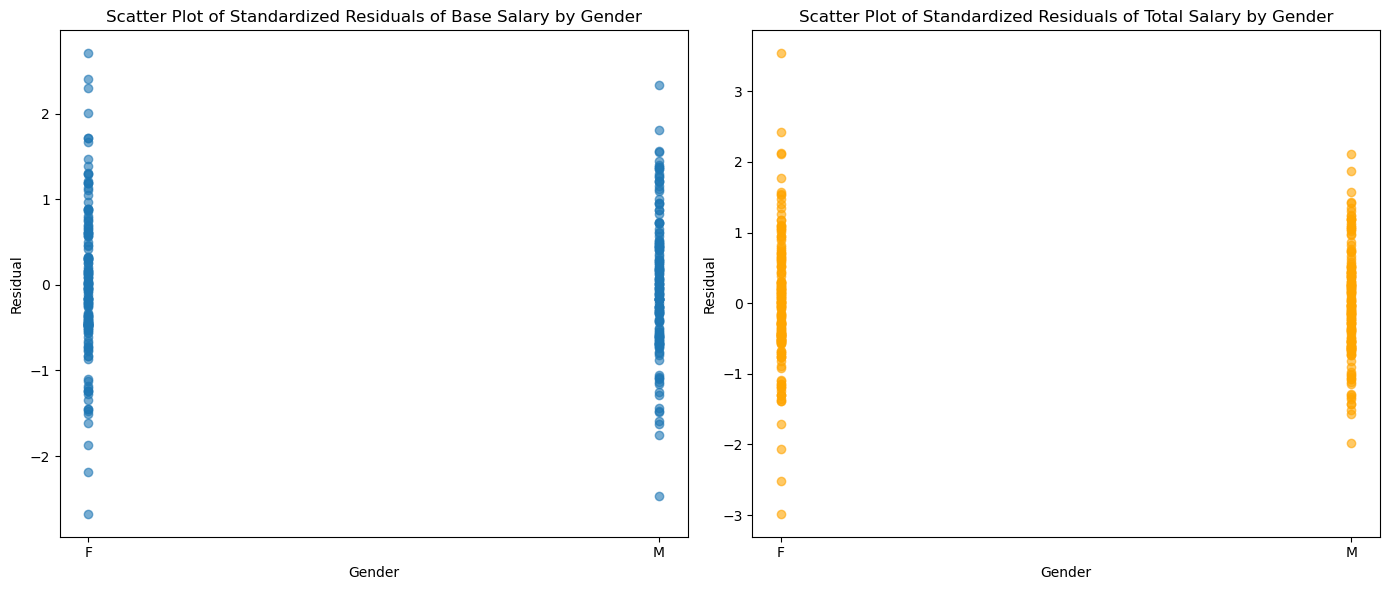

In [50]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].scatter(resid['Gender'], resid['Base_Salary'], alpha=0.6)
axes[0].set_xlabel('Gender')
axes[0].set_ylabel('Residual')
axes[0].set_title('Scatter Plot of Standardized Residuals of Base Salary by Gender')

axes[1].scatter(resid['Gender'], resid['Total_Salary'], alpha=0.6, color='orange')
axes[1].set_xlabel('Gender')
axes[1].set_ylabel('Residual')
axes[1].set_title('Scatter Plot of Standardized Residuals of Total Salary by Gender')

plt.tight_layout()
plt.show()

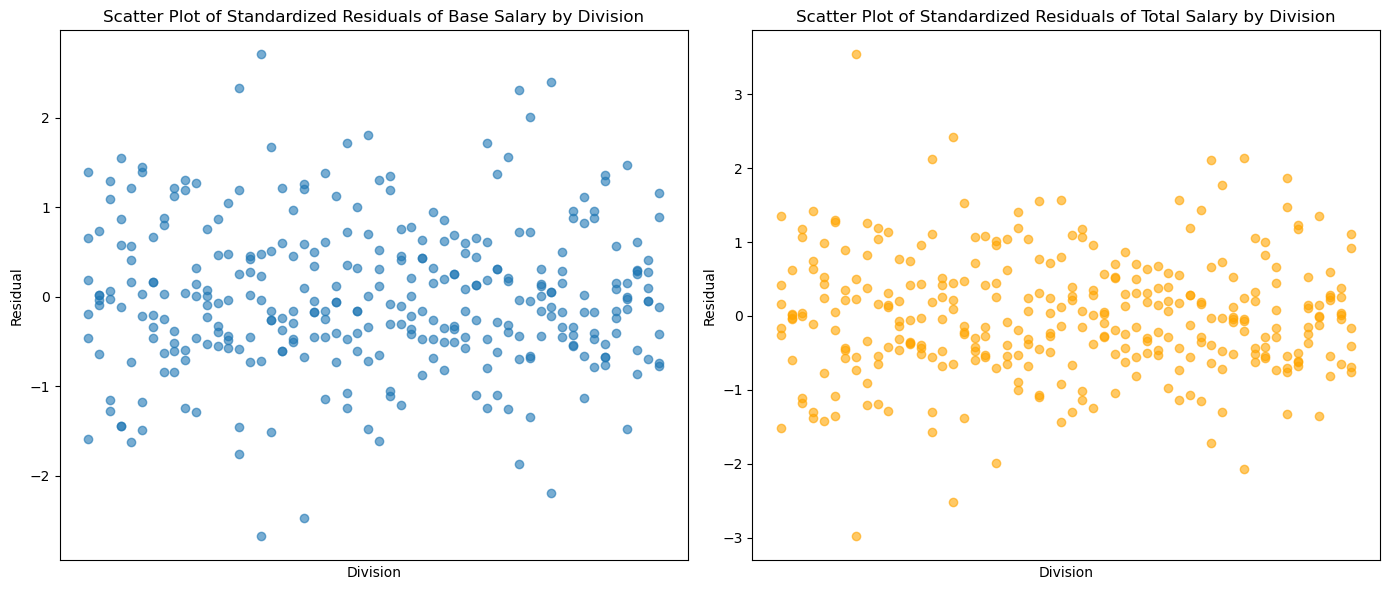

In [51]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].scatter(resid['Division'], resid['Base_Salary'], alpha=0.6)
axes[0].set_xlabel('Division')
axes[0].set_ylabel('Residual')
axes[0].set_title('Scatter Plot of Standardized Residuals of Base Salary by Division')
axes[0].set_xticks([])

axes[1].scatter(resid['Division'], resid['Total_Salary'], alpha=0.6, color='orange')
axes[1].set_xlabel('Division')
axes[1].set_ylabel('Residual')
axes[1].set_title('Scatter Plot of Standardized Residuals of Total Salary by Division')
axes[1].set_xticks([])

plt.tight_layout()
plt.show()

## Independence

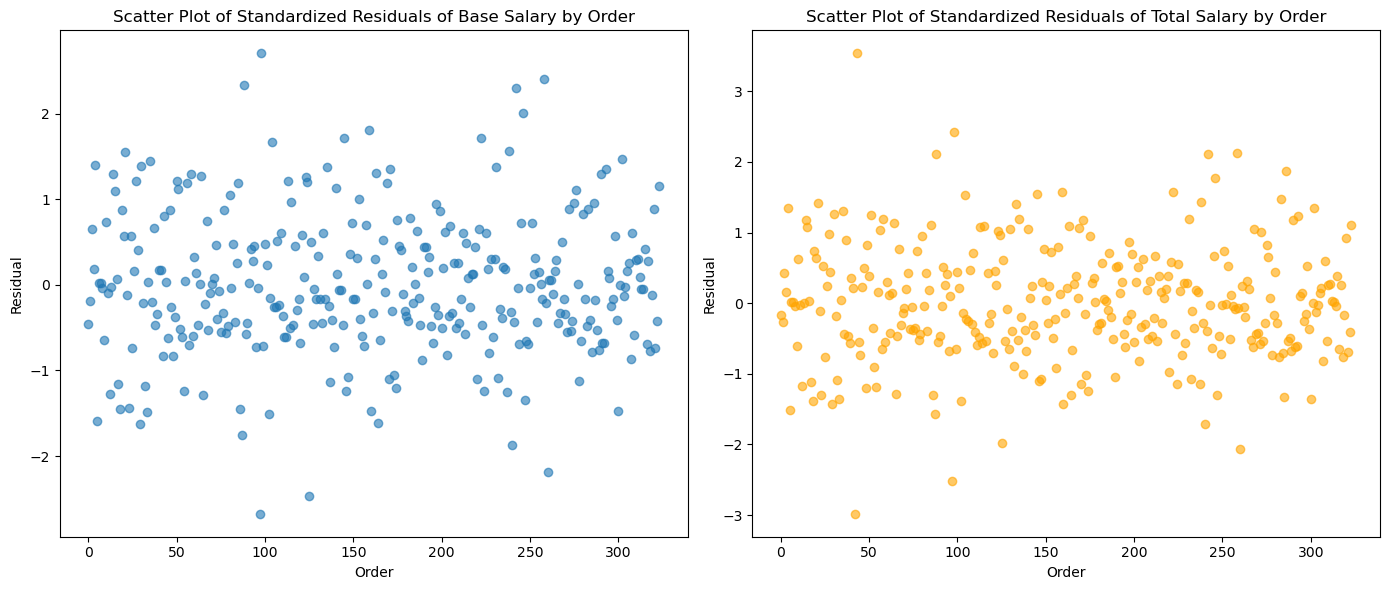

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].scatter(resid.index, resid['Base_Salary'], alpha=0.6)
axes[0].set_xlabel('Order')
axes[0].set_ylabel('Residual')
axes[0].set_title('Scatter Plot of Standardized Residuals of Base Salary by Order')

axes[1].scatter(resid.index, resid['Total_Salary'], alpha=0.6, color='orange')
axes[1].set_xlabel('Order')
axes[1].set_ylabel('Residual')
axes[1].set_title('Scatter Plot of Standardized Residuals of Total Salary by Order')

plt.tight_layout()
plt.show()

## Homoscedasticity

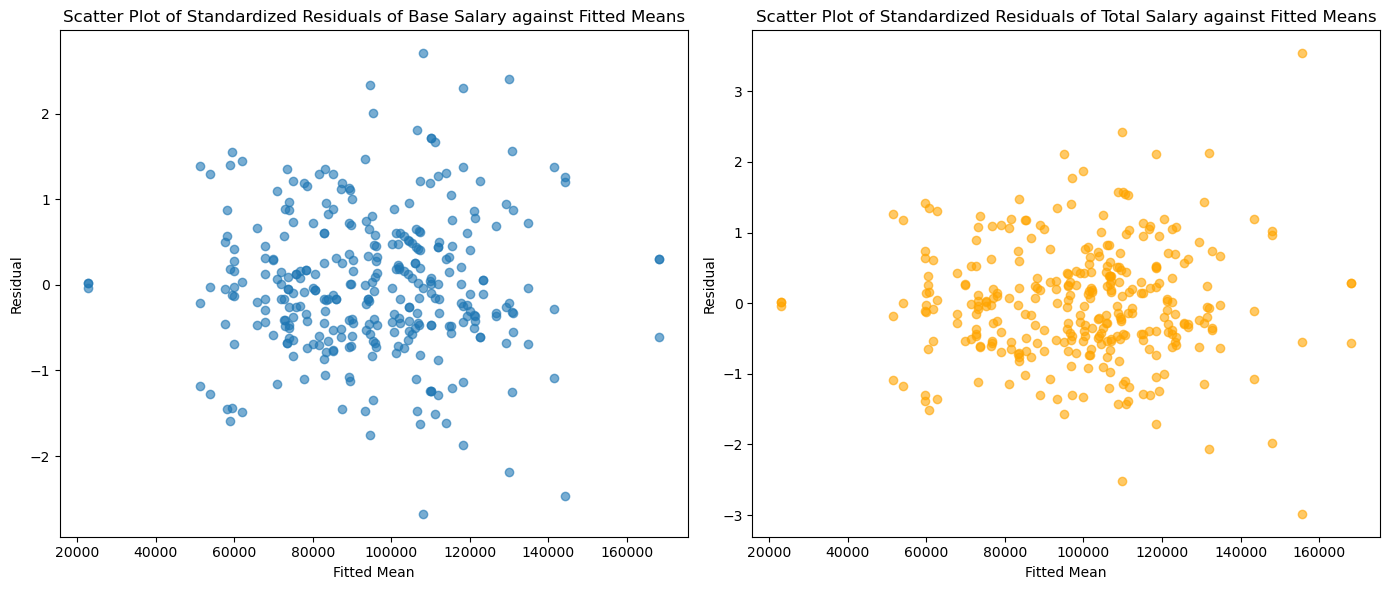

In [53]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].scatter(group_means['Base_Salary'], resid['Base_Salary'], alpha=0.6)
axes[0].set_xlabel('Fitted Mean')
axes[0].set_ylabel('Residual')
axes[0].set_title('Scatter Plot of Standardized Residuals of Base Salary against Fitted Means')

axes[1].scatter(group_means['Total_Salary'], resid['Total_Salary'], alpha=0.6, color='orange')
axes[1].set_xlabel('Fitted Mean')
axes[1].set_ylabel('Residual')
axes[1].set_title('Scatter Plot of Standardized Residuals of Total Salary against Fitted Means')

plt.tight_layout()
plt.show()

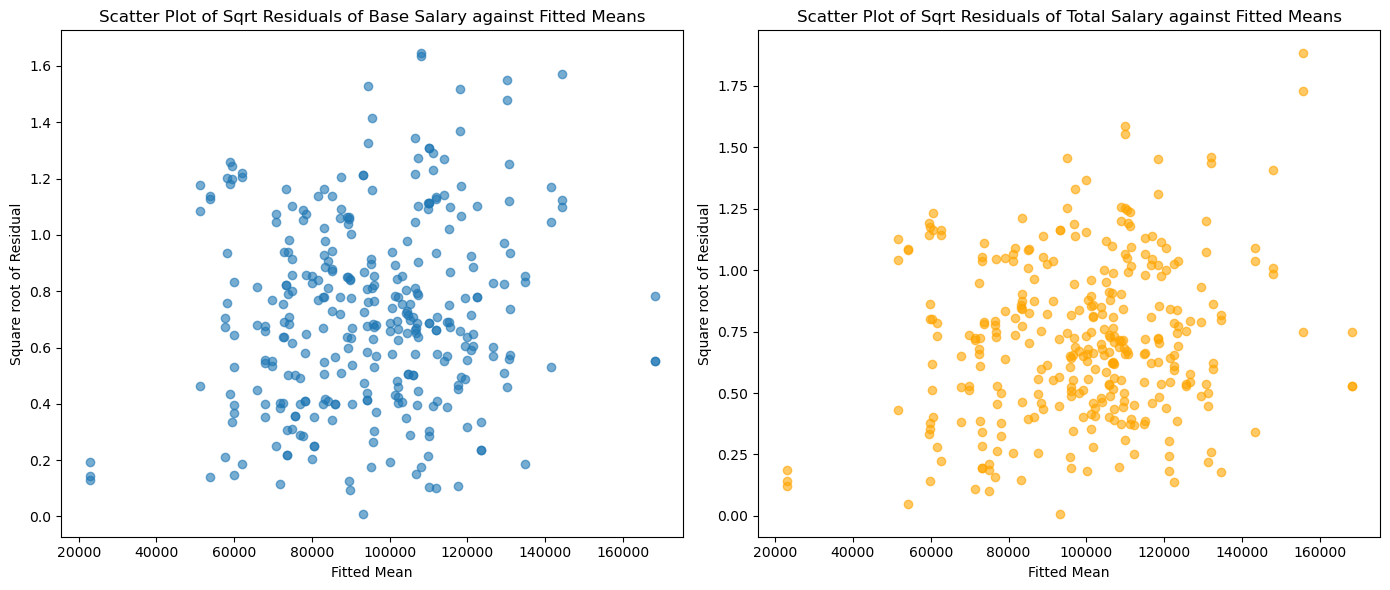

In [54]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].scatter(group_means['Base_Salary'], np.sqrt(np.abs(resid['Base_Salary'])), alpha=0.6)
axes[0].set_xlabel('Fitted Mean')
axes[0].set_ylabel('Square root of Residual')
axes[0].set_title('Scatter Plot of Sqrt Residuals of Base Salary against Fitted Means')

axes[1].scatter(group_means['Total_Salary'], np.sqrt(np.abs(resid['Total_Salary'])), alpha=0.6, color='orange')
axes[1].set_xlabel('Fitted Mean')
axes[1].set_ylabel('Square root of Residual')
axes[1].set_title('Scatter Plot of Sqrt Residuals of Total Salary against Fitted Means')

plt.tight_layout()
plt.show()

In [55]:
groups = []
for (dom,dep,div,gen), group_data in df2.groupby(['Domain', 'Department', 'Division', 'Gender']):
    groups.append(group_data['Total_Salary'])
levene_test_result = stats.levene(*groups)
print("Levene's Test Result:")
print("Statistic:", levene_test_result.statistic)
print("p-value:", levene_test_result.pvalue)

Levene's Test Result:
Statistic: 0.6876018644501382
p-value: 0.9848597142844808


In [56]:
groups = []
for (dom,dep,div,gen), group_data in df2.groupby(['Domain', 'Department', 'Division', 'Gender']):
    groups.append(group_data['Base_Salary'])
levene_test_result = stats.levene(*groups)
print("Levene's Test Result:")
print("Statistic:", levene_test_result.statistic)
print("p-value:", levene_test_result.pvalue)

Levene's Test Result:
Statistic: 0.6649645053301064
p-value: 0.9907710547390327


In [57]:
groups = []
for (dom,dep,div,gen), group_data in df2.groupby(['Domain', 'Department', 'Division', 'Gender']):
    groups.append(group_data['Overtime_Pay'])
levene_test_result = stats.levene(*groups)
print("Levene's Test Result:")
print("Statistic:", levene_test_result.statistic)
print("p-value:", levene_test_result.pvalue)

Levene's Test Result:
Statistic: 1.8828498110879976
p-value: 4.699327897573723e-05


In [58]:
groups = []
for (dom,dep,div,gen), group_data in df2.groupby(['Domain', 'Department', 'Division', 'Gender']):
    groups.append(group_data['Longevity_Pay'])
levene_test_result = stats.levene(*groups)
print("Levene's Test Result:")
print("Statistic:", levene_test_result.statistic)
print("p-value:", levene_test_result.pvalue)

Levene's Test Result:
Statistic: 0.6604364714166475
p-value: 0.9916885959916474


## Normality

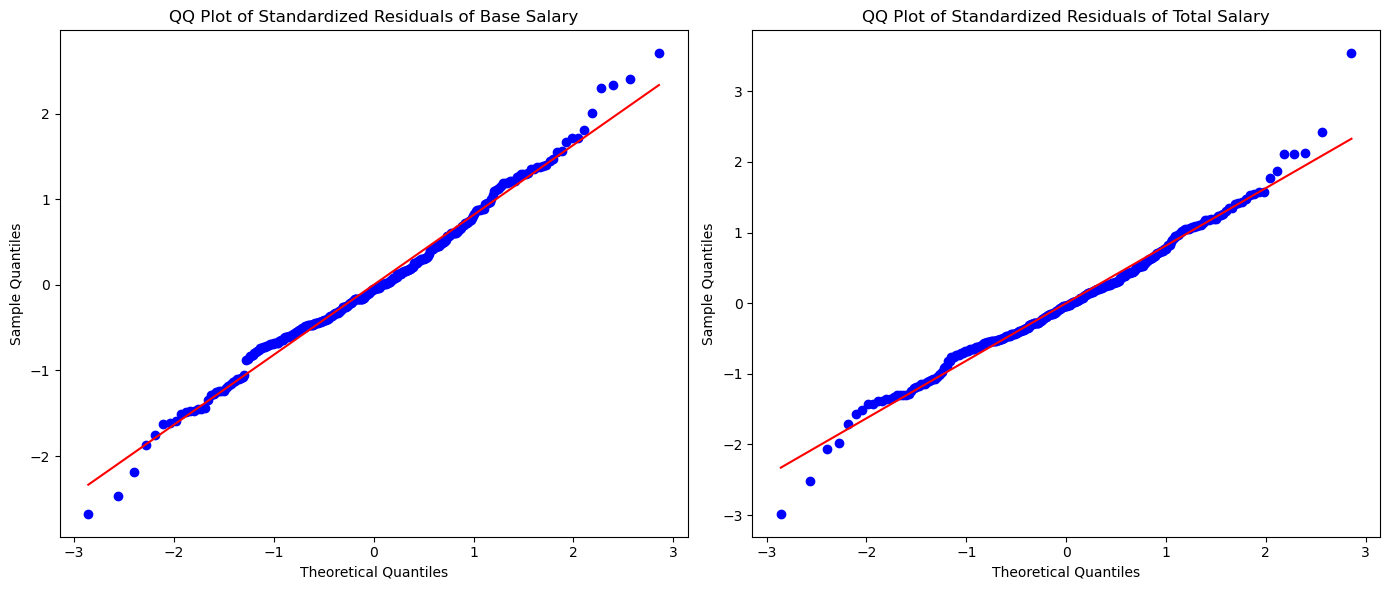

In [59]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

stats.probplot(resid['Base_Salary'], dist="norm", plot=axes[0])
axes[0].set_title('QQ Plot of Standardized Residuals of Base Salary')
axes[0].set_xlabel('Theoretical Quantiles')
axes[0].set_ylabel('Sample Quantiles')

stats.probplot(resid['Total_Salary'], dist="norm", plot=axes[1])
axes[1].set_title('QQ Plot of Standardized Residuals of Total Salary')
axes[1].set_xlabel('Theoretical Quantiles')
axes[1].set_ylabel('Sample Quantiles')

plt.tight_layout()
plt.show()

# ANOVA

Model: $y_{ijklm}^{(n)}=\mu^{(n)}+\alpha_{i}^{(n)}+\beta_{j}^{(n)}+(\alpha\beta)_{ij}^{(n)}+\gamma_{jk}^{(n)}+(\alpha\gamma)_{ijk}^{(n)}+\delta_{jkl}^{(n)}+(\alpha\delta)_{ijkl}^{(n)}+\varepsilon_{ijklm}^{(n)}$.

In [60]:
def P(anova, var_num, var_don):
    mse1 = anova.loc[var_num,'mean_sq']
    mse2 = anova.loc[var_don,'mean_sq']
    F = sum(mse1) / sum(mse2)
    df_1 = anova.loc[var_num,'df']
    df1 = (sum(mse1) ** 2) / sum((mse1 ** 2) / df_1)
    df_2 = anova.loc[var_don,'df']
    df2 = (sum(mse2) ** 2) / sum((mse2 ** 2) / df_2)
    p = 1-stats.f.cdf(F, df1, df2)
    return F, p

##  Total

In [61]:
formula = 'Total_Salary ~ Domain + Domain:Department + Domain:Department:Division + Domain*Gender + Domain:Department*Gender + Domain:Department:Division*Gender'
model = ols(formula, data=df2).fit()
anova_table = sm.stats.anova_lm(model, typ=1)
anova_table

,df,sum_sq,mean_sq,F,PR(>F)
Domain,2.0,2.057873e+10,1.028937e+10,13.802462,2.285127e-06
Gender,1.0,4.558272e+08,4.558272e+08,0.611460,4.350949e-01
Domain:Department,6.0,5.214181e+10,8.690302e+09,11.657428,2.641730e-11
Domain:Gender,2.0,2.230723e+09,1.115361e+09,1.496179,2.262963e-01
Domain:Department:Division,45.0,7.517109e+10,1.670469e+09,2.240816,6.638096e-05
Domain:Department:Gender,6.0,4.415859e+09,7.359766e+08,0.987261,4.347563e-01
Domain:Department:Division:Gender,45.0,2.757917e+10,6.128705e+08,0.822123,7.806401e-01
Residual,216.0,1.610222e+11,7.454733e+08,NaN,NaN


In [62]:
# A: Gender, B: Domain, C: Department, D: Division
# Effect: fixed, fixed, random, random (recommended)
results_total_1 = {
    'A': P(anova_table,var_num = ['Gender'],var_don = ['Domain:Department:Gender']),
    'B': P(anova_table,var_num = ['Domain'],var_don = ['Domain:Department']),
    'AB': P(anova_table,var_num = ['Domain:Gender'],var_don = ['Domain:Department:Gender']),
    'C(B)': P(anova_table,var_num = ['Domain:Department','Domain:Department:Division:Gender'],var_don = ['Domain:Department:Gender','Domain:Department:Division']),
    'AC(B)': P(anova_table,var_num = ['Domain:Department:Gender'],var_don = ['Domain:Department:Division:Gender']),
    'D(C)': P(anova_table,var_num = ['Domain:Department:Division'],var_don = ['Domain:Department:Division:Gender']),
    'AD(C)': P(anova_table,var_num = ['Domain:Department:Division:Gender'],var_don = ['Residual']),
}
results_total_1

{'A': (0.619350195513775, 0.461234351254852),
 'B': (1.184005727724831, 0.36862683969721366),
 'AB': (1.515484923527206, 0.29325847675543204),
 'C(B)': (3.8659397975176004, 0.0029987256356165393),
 'AC(B)': (1.2008680714938884, 0.3233942331298929),
 'D(C)': (2.7256470716793864, 0.0005216771873221004),
 'AD(C)': (0.8221226111088954, 0.7806400859560076)}

In [63]:
# Effect: fixed, fixed, fixed, random
results_total_2 = {
    'A': P(anova_table,var_num = ['Gender'],var_don = ['Domain:Department:Division:Gender']),
    'B': P(anova_table,var_num = ['Domain'],var_don = ['Domain:Department:Division']),
    'AB': P(anova_table,var_num = ['Domain:Gender'],var_don = ['Domain:Department:Division:Gender']),
    'C(B)': P(anova_table,var_num = ['Domain:Department'],var_don = ['Domain:Department:Division']),
    'AC(B)': P(anova_table,var_num = ['Domain:Department:Gender'],var_don = ['Domain:Department:Division:Gender']),
    'D(C)': P(anova_table,var_num = ['Domain:Department:Division'],var_don = ['Domain:Department:Division:Gender']),
    'AD(C)': P(anova_table,var_num = ['Domain:Department:Division:Gender'],var_don = ['Residual']),
}
results_total_2

{'A': (0.7437578748659898, 0.39303260034631415),
 'B': (6.159569242194076, 0.004320553021032847),
 'AB': (1.819897457494179, 0.17376708671139163),
 'C(B)': (5.20231372024713, 0.00038760708130125554),
 'AC(B)': (1.2008680714938884, 0.3233942331298929),
 'D(C)': (2.7256470716793864, 0.0005216771873221004),
 'AD(C)': (0.8221226111088954, 0.7806400859560076)}

## Base

In [64]:
formula = 'Base_Salary ~ Domain + Domain:Department + Domain:Department:Division + Domain*Gender + Domain:Department*Gender + Domain:Department:Division*Gender'
model = ols(formula, data=df2).fit()
anova_table_base = sm.stats.anova_lm(model, typ=1)
anova_table_base

,df,sum_sq,mean_sq,F,PR(>F)
Domain,2.0,3.106562e+10,1.553281e+10,24.789190,2.033254e-10
Gender,1.0,4.322969e+08,4.322969e+08,0.689913,4.071111e-01
Domain:Department,6.0,3.872419e+10,6.454031e+09,10.300144,4.987857e-10
Domain:Gender,2.0,1.856072e+09,9.280358e+08,1.481075,2.296931e-01
Domain:Department:Division,45.0,7.226099e+10,1.605800e+09,2.562735,3.362136e-06
Domain:Department:Gender,6.0,3.439112e+09,5.731853e+08,0.914760,4.851003e-01
Domain:Department:Division:Gender,45.0,2.490313e+10,5.534029e+08,0.883189,6.832163e-01
Residual,216.0,1.353448e+11,6.265962e+08,NaN,NaN


In [65]:
# Effect: fixed, fixed, random, random (recommended)
results_base_1 = {
    'A': P(anova_table_base,var_num = ['Gender'],var_don = ['Domain:Department:Gender']),
    'B': P(anova_table_base,var_num = ['Domain'],var_don = ['Domain:Department']),
    'AB': P(anova_table_base,var_num = ['Domain:Gender'],var_don = ['Domain:Department:Gender']),
    'C(B)': P(anova_table_base,var_num = ['Domain:Department','Domain:Department:Division:Gender'],var_don = ['Domain:Department:Gender','Domain:Department:Division']),
    'AC(B)': P(anova_table_base,var_num = ['Domain:Department:Gender'],var_don = ['Domain:Department:Division:Gender']),
    'D(C)': P(anova_table_base,var_num = ['Domain:Department:Division'],var_don = ['Domain:Department:Division:Gender']),
    'AD(C)': P(anova_table_base,var_num = ['Domain:Department:Division:Gender'],var_don = ['Residual']),
}
results_base_1

{'A': (0.7542009251137184, 0.4185267866142268),
 'B': (2.4066838671955693, 0.17083263266751336),
 'AB': (1.6190850530038714, 0.2739655065526292),
 'C(B)': (3.2159164470945845, 0.007836930004293863),
 'AC(B)': (1.0357468415009523, 0.41501243962007495),
 'D(C)': (2.9016829727703883, 0.0002557056031141647),
 'AD(C)': (0.8831890397387034, 0.6832162815462994)}

In [66]:
# Effect: fixed, fixed, fixed, random
results_base_2 = {
    'A': P(anova_table_base,var_num = ['Gender'],var_don = ['Domain:Department:Division:Gender']),
    'B': P(anova_table_base,var_num = ['Domain'],var_don = ['Domain:Department:Division']),
    'AB': P(anova_table_base,var_num = ['Domain:Gender'],var_don = ['Domain:Department:Division:Gender']),
    'C(B)': P(anova_table_base,var_num = ['Domain:Department'],var_don = ['Domain:Department:Division']),
    'AC(B)': P(anova_table_base,var_num = ['Domain:Department:Gender'],var_don = ['Domain:Department:Division:Gender']),
    'D(C)': P(anova_table_base,var_num = ['Domain:Department:Division'],var_don = ['Domain:Department:Division:Gender']),
    'AD(C)': P(anova_table_base,var_num = ['Domain:Department:Division:Gender'],var_don = ['Residual']),
}
results_base_2

{'A': (0.7811612260436301, 0.3814840295522467),
 'B': (9.672944707100838, 0.0003203047465295539),
 'AB': (1.6769622297701618, 0.19841188680024413),
 'C(B)': (4.019200377311045, 0.0026304941614815336),
 'AC(B)': (1.0357468415009523, 0.41501243962007495),
 'D(C)': (2.9016829727703883, 0.0002557056031141647),
 'AD(C)': (0.8831890397387034, 0.6832162815462994)}

## Overtime

In [67]:
# formula = 'Overtime_Pay ~ Domain + Domain:Department + Domain:Department:Division + Domain*Gender + Domain:Department*Gender + Domain:Department:Division*Gender'
# model = ols(formula, data=df2).fit()
# anova_table_Overtime = sm.stats.anova_lm(model, typ=1)
# anova_table_Overtime

In [68]:
# #A: Gender, B: Domain, C: Department, D: Division.
# #Effect: fixed, fixed, random, random (recommended).
# p_values10 = {
#     'p_A': P(anova_table_Overtime,var_num = ['Gender'],var_don = ['Domain:Department:Gender']),
#     'p_B': P(anova_table_Overtime,var_num = ['Domain'],var_don = ['Domain:Department']),
#     'p_AB': P(anova_table_Overtime,var_num = ['Domain:Gender'],var_don = ['Domain:Department:Gender']),
#     'p_C(B)': P(anova_table_Overtime,var_num = ['Domain:Department','Domain:Department:Division:Gender'],var_don = ['Domain:Department:Gender','Domain:Department:Division']),
#     'p_AC(B)': P(anova_table_Overtime,var_num = ['Domain:Department:Gender'],var_don = ['Domain:Department:Division:Gender']),
#     'p_D(C)': P(anova_table_Overtime,var_num = ['Domain:Department:Division'],var_don = ['Domain:Department:Division:Gender']),
#     'p_AD(C)': P(anova_table_Overtime,var_num = ['Domain:Department:Division:Gender'],var_don = ['Residual']),
# }
# p_values10

In [69]:
# #Effect: fixed, fixed, fixed, random.
# p_values11 = {
#     'p_A': P(anova_table_Overtime,var_num = ['Gender'],var_don = ['Domain:Department:Division:Gender']),
#     'p_B': P(anova_table_Overtime,var_num = ['Domain'],var_don = ['Domain:Department:Division']),
#     'p_AB': P(anova_table_Overtime,var_num = ['Domain:Gender'],var_don = ['Domain:Department:Division:Gender']),
#     'p_C(B)': P(anova_table_Overtime,var_num = ['Domain:Department'],var_don = ['Domain:Department:Division']),
#     'p_AC(B)': P(anova_table_Overtime,var_num = ['Domain:Department:Gender'],var_don = ['Domain:Department:Division:Gender']),
#     'p_D(C)': P(anova_table_Overtime,var_num = ['Domain:Department:Division'],var_don = ['Domain:Department:Division:Gender']),
#     'p_AD(C)': P(anova_table_Overtime,var_num = ['Domain:Department:Division:Gender'],var_don = ['Residual']),
# }
# p_values11

In [70]:
data17 = df2.copy()
data17.groupby(data17['Longevity_Pay'] == 0)['Base_Salary'].median(), data17.groupby(data17['Longevity_Pay'] == 0)['Base_Salary'].mean()

(Longevity_Pay
 False    105345.0
 True      89250.0
 Name: Base_Salary, dtype: float64,
 Longevity_Pay
 False    101496.562898
 True      92596.099074
 Name: Base_Salary, dtype: float64)

# Post hoc analysis

Model: $y_{ijklm}^{(n)}=\mu^{(n)}+\gamma_{jk}^{(n)}+\delta_{jkl}^{(n)}+\varepsilon_{ijklm}^{(n)}$.

$\gamma_{jk}^{(n)}\sim\text{N}(0,\sigma_{\gamma,n}^2,), \delta_{jkl}^{(n)}\sim\text{N}(0,\sigma_{\delta,n}^2), \varepsilon_{ijklm}^{(n)}\sim\text{N}(0,\sigma_{\varepsilon,n}^2)$.

## Estimating Standard Deviations

In [71]:
sigma_error = np.sqrt([anova_table_base.loc['Residual','mean_sq'],
                       anova_table.loc['Residual','mean_sq']])
sigma_error.round(0)

array([25032., 27303.])

In [72]:
sigma_d = np.sqrt([anova_table_base.loc['Domain:Department:Division','mean_sq']-anova_table_base.loc['Domain:Department:Division:Gender','mean_sq'],
                   anova_table.loc['Domain:Department:Division','mean_sq']-anova_table.loc['Domain:Department:Division:Gender','mean_sq']])
sigma_d /= np.sqrt(6)
sigma_d.round(0)

array([13244., 13277.])

In [73]:
MSN = [anova_table_base.loc['Domain:Department','mean_sq']+anova_table_base.loc['Domain:Department:Division:Gender','mean_sq'],
       anova_table.loc['Domain:Department','mean_sq']+anova_table.loc['Domain:Department:Division:Gender','mean_sq']]
MSD = [anova_table_base.loc['Domain:Department:Division','mean_sq']+anova_table_base.loc['Domain:Department:Gender','mean_sq'],
       anova_table.loc['Domain:Department:Division','mean_sq']+anova_table.loc['Domain:Department:Gender','mean_sq']]
sigma_c = np.sqrt((np.array(MSN) - np.array(MSD)) / 36)
sigma_c.round(0)

array([11581., 13841.])

## Estimating Means

### Division

In [74]:
var_div = [anova_table_base.loc['Residual','mean_sq'] / 6,
           anova_table.loc['Residual','mean_sq'] / 6]
std_div = np.sqrt(np.array(var_div))
df_div = anova_table_base.loc['Residual','df']
range_div = stats.t.ppf(0.95, df_div) * std_div

lower_div = df1.groupby(['Division'])[['Base_Salary','Total_Salary']].mean() - range_div
upper_div = df1.groupby(['Division'])[['Base_Salary','Total_Salary']].mean() + range_div

bound_div = pd.DataFrame()
bound_div['Base_lower'] = lower_div['Base_Salary']
bound_div['Base_upper'] = upper_div['Base_Salary']
bound_div['Total_lower'] = lower_div['Total_Salary']
bound_div['Total_upper'] = upper_div['Total_Salary']
bound_div.round(0)

,Base_lower,Base_upper,Total_lower,Total_upper
Division,,,,
ABS 85 Administrative Services,59749.0,93512.0,61445.0,98272.0
ABS 85 Aspen Hill,31966.0,65729.0,31271.0,68098.0
ABS 85 Kingsview,45428.0,79191.0,45209.0,82036.0
ABS 85 Leisure World,41846.0,75609.0,41213.0,78040.0
ABS 85 Retail Administration,88355.0,122118.0,89986.0,126813.0
ABS 85 Walnut Hill,39746.0,73509.0,38673.0,75500.0
COR 42 DS Inmate Records,55097.0,88860.0,61961.0,98788.0
COR 42 DS MCCF Unit 1 Security,67661.0,101424.0,118730.0,155557.0
COR 42 DS MCCF Unit 2 Security,64195.0,97958.0,87394.0,124220.0


### Department

In [75]:
var_dept = [anova_table_base.loc['Domain:Department:Division','mean_sq'] / 36,
            anova_table.loc['Domain:Department:Division','mean_sq'] / 36]
std_dept = np.sqrt(np.array(var_dept))
df_dept = anova_table_base.loc['Domain:Department:Division','df']
range_dept = stats.t.ppf(0.95, df_dept) * std_dept

lower_dept = df1.groupby(['Department_Name'])[['Base_Salary','Total_Salary']].mean() - range_dept
upper_dept = df1.groupby(['Department_Name'])[['Base_Salary','Total_Salary']].mean() + range_dept

bound_dept = pd.DataFrame()
bound_dept['Base_lower'] = lower_dept['Base_Salary']
bound_dept['Base_upper'] = upper_dept['Base_Salary']
bound_dept['Total_lower'] = lower_dept['Total_Salary']
bound_dept['Total_upper'] = upper_dept['Total_Salary']
bound_dept.round(0)

,Base_lower,Base_upper,Total_lower,Total_upper
Department_Name,,,,
Alcohol Beverage Services,56847.0,79280.0,58273.0,81153.0
Correction and Rehabilitation,78701.0,101134.0,93926.0,116806.0
Department of Environmental Protection,93179.0,115611.0,93958.0,116838.0
Department of Finance,102480.0,124912.0,102990.0,125870.0
Department of General Services,84342.0,106774.0,89326.0,112206.0
Department of Permitting Services,103004.0,125437.0,104872.0,127752.0
Department of Police,83021.0,105453.0,90656.0,113536.0
Department of Recreation,64702.0,87135.0,64972.0,87853.0
Department of Transportation,87651.0,110084.0,92163.0,115043.0


### Overall

In [76]:
var_overall = [anova_table_base.loc['Domain:Department','mean_sq'] / 324,
               anova_table.loc['Domain:Department','mean_sq'] / 324]
std_overall = np.sqrt(np.array(var_overall))
df_overall = anova_table_base.loc['Domain:Department','df']
range_overall = stats.t.ppf(0.95, df_overall) * std_overall

lower_overall = df1[['Base_Salary','Total_Salary']].mean() - range_overall
upper_overall = df1[['Base_Salary','Total_Salary']].mean() + range_overall

bound_overall = pd.Series()
bound_overall['Base_lower'] = lower_overall['Base_Salary']
bound_overall['Base_upper'] = upper_overall['Base_Salary']
bound_overall['Total_lower'] = lower_overall['Total_Salary']
bound_overall['Total_upper'] = upper_overall['Total_Salary']
bound_overall.round(0)

Base_lower      86313.0
Base_upper     103659.0
Total_lower     89280.0
Total_upper    109408.0
dtype: float64

## Sample Size

In [77]:
data['Department_Name'].nunique()

42

In [78]:
# how many departments (n) per domain are needed to detect a 100r% std of domain compared with department

def power(r, n):
    df1, df2 = 2, 3 * (n-1)
    cv = stats.f.ppf(0.95, df1, df2) / (1+n*r**2)
    return 1 - stats.f.cdf(cv, df1, df2)

power(1.5, 7), power(1, 14)

(0.8107876318171424, 0.8067939919996308)

In [79]:
power(1.5, 5), power(1, 9), power(0.8, 13)

(0.7341307555713057, 0.7149467282678293, 0.7072493968772449)

In [80]:
def power(r, n):
    df1, df2 = 2, 3 * (n-1)
    add = (sigma_error/sigma_c)**2/36 + (sigma_d/sigma_c)**2/6 + 1
    cv = stats.f.ppf(0.95, df1, df2) / (1+n*r**2/add)
    return 1 - stats.f.cdf(cv, df1, df2)

power(1.5, 9), power(1.1, 14)

(array([0.81019169, 0.82045018]), array([0.7888447 , 0.80000875]))

In [204]:
# detect an 100p% increase in the variability of a single observation if domain is considered
# c: number of departments per domain
# d: number of divisions per department
# n: number of obeservations per division
cost_c, cost_d = 200, 10

def power(p, c, d, n):
    df1, df2 = 2, 3 * (c-1)
    theta_b_sq = (p**2+2*p) * (sigma_c**2+sigma_d**2+sigma_error**2)
    EMSC = sigma_error**2 + n*sigma_d**2 + d*n*sigma_c**2
    EMSB = EMSC + c*d*n*theta_b_sq
    cv = stats.f.ppf(0.95, df1, df2) / EMSB * EMSC
    return {'power': 1 - stats.f.cdf(cv, df1, df2),
            'total observation': 3*c*d*n,
            'cost': 3*c*cost_c + 3*c*d*cost_d + 3*c*d*n}

# power if keep the design
power(0.1, 3, 6, 6), power(0.2, 3, 6, 6)

({'power': array([0.36271891, 0.33536741]),
  'total observation': 324,
  'cost': 2664},
 {'power': array([0.5523495, 0.5218187]),
  'total observation': 324,
  'cost': 2664})

In [205]:
# new design to reach a power of 80%

power(0.2, 9, 3, 4), power(0.2, 8, 4, 6), power(0.2, 7, 7, 7)

({'power': array([0.81142249, 0.8000218 ]),
  'total observation': 324,
  'cost': 6534},
 {'power': array([0.81851082, 0.80363348]),
  'total observation': 576,
  'cost': 6336},
 {'power': array([0.82046568, 0.80055104]),
  'total observation': 1029,
  'cost': 6699})

In [210]:
power(0.1, 14, 6, 6), power(0.1, 13, 8, 9), power(0.1, 12, 16, 14)

({'power': array([0.81991516, 0.80141663]),
  'total observation': 1512,
  'cost': 12432},
 {'power': array([0.82174495, 0.80066007]),
  'total observation': 2808,
  'cost': 13728},
 {'power': array([0.82477087, 0.80003256]),
  'total observation': 8064,
  'cost': 21024})